In [1]:
import netCDF4
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

import subprocess
from matplotlib.animation import FuncAnimation
import matplotlib.patches as patches
from matplotlib.colors import ListedColormap
from scipy.io import loadmat
import natsort, pathlib
import os
import glob

In [2]:
colormap_data = loadmat('cold2hot.mat')
cold2hot = ListedColormap(colormap_data['colormap'])
hot2cold = ListedColormap(colormap_data['colormap'][::-1])

# Gaussian HS

## TDB Free Energy

In [3]:
path = os.path.abspath('../../0_MOOSE_Input_Files/Heat_Sources/Gaussian/TDB/exodus/')

In [4]:
model_path = path+'/Au-Au.e'
model = netCDF4.Dataset(model_path)

In [5]:
model.dimensions

{'len_name': "<class 'netCDF4.Dimension'>": name = 'len_name', size = 256,
 'time_step': "<class 'netCDF4.Dimension'>" (unlimited): name = 'time_step', size = 543,
 'num_dim': "<class 'netCDF4.Dimension'>": name = 'num_dim', size = 2,
 'num_nodes': "<class 'netCDF4.Dimension'>": name = 'num_nodes', size = 80601,
 'num_elem': "<class 'netCDF4.Dimension'>": name = 'num_elem', size = 20000,
 'num_el_blk': "<class 'netCDF4.Dimension'>": name = 'num_el_blk', size = 1,
 'num_node_sets': "<class 'netCDF4.Dimension'>": name = 'num_node_sets', size = 4,
 'num_side_sets': "<class 'netCDF4.Dimension'>": name = 'num_side_sets', size = 4,
 'num_el_in_blk1': "<class 'netCDF4.Dimension'>": name = 'num_el_in_blk1', size = 20000,
 'num_nod_per_el1': "<class 'netCDF4.Dimension'>": name = 'num_nod_per_el1', size = 9,
 'num_side_ss1': "<class 'netCDF4.Dimension'>": name = 'num_side_ss1', size = 200,
 'num_side_ss2': "<class 'netCDF4.Dimension'>": name = 'num_side_ss2', size = 100,
 'num_side_ss3': "<class

In [6]:
model.variables.keys()

dict_keys(['time_whole', 'eb_status', 'eb_prop1', 'ns_status', 'ns_prop1', 'ss_status', 'ss_prop1', 'coordx', 'coordy', 'eb_names', 'ns_names', 'ss_names', 'coor_names', 'node_num_map', 'connect1', 'elem_num_map', 'elem_ss1', 'side_ss1', 'elem_ss2', 'side_ss2', 'elem_ss3', 'side_ss3', 'elem_ss4', 'side_ss4', 'node_ns1', 'node_ns2', 'node_ns3', 'node_ns4', 'name_nod_var', 'vals_nod_var1', 'vals_nod_var2', 'vals_nod_var3', 'vals_nod_var4', 'vals_nod_var5', 'name_elem_var', 'vals_elem_var1eb1', 'elem_var_tab', 'name_glo_var', 'vals_glo_var', 'info_records'])

In [7]:
names = model.variables["name_nod_var"]
names.set_auto_mask(False)
param_in_exodus = [b"".join(c).decode("latin1") for c in names[:]]
print(param_in_exodus)

['eta1', 'p', 'temp', 'vel_x', 'vel_y']


In [8]:
parameters = ['vals_nod_var1', 'vals_nod_var2', 'vals_nod_var3', 'vals_nod_var4', 'vals_nod_var5',]

In [ ]:
area_df1 = pd.read_csv(path+'/Au-Au.csv',  encoding='utf-8')
real_time = np.array(area_df1['time'])
area_df1.head()

In [ ]:
LIQ, press, temp, velX, velY = [], [], [], [], []

for i in range(5):
    param = model.variables[parameters[i]][:]

    X_all = model.variables['coordx'][:]
    Y_all = model.variables['coordy'][:]
    
    points = np.vstack([Y_all,X_all,param]).T
    
    column_names = ['X', 'Y'] + list(range(param.shape[0]))
    df = pd.DataFrame(points, columns=column_names)
    df = df.sort_values(by = ['X', 'Y'], ascending = [True, True], ignore_index=True)
    df_param = df.iloc[:, 2:]
    
    x_dim  = model.dimensions['num_nod_ns1'].size
    y_dim =  model.dimensions['num_nod_ns2'].size
    time_steps = model.dimensions['time_step'].size
    array_ = df_param.to_numpy().flatten().reshape(y_dim, x_dim, time_steps)
    array = np.flip(array_, axis=0)
    if i == 0:
        LIQ.append(array)
    elif i == 1:
        press.append(array)
    elif i == 2:
        temp.append(array)
    elif i == 3:
        velX.append(array)
    else:
        velY.append(array)

# time = np.array(model.variables['time_whole'][:]).reshape((-1, ))
# LIQ, press, temp, velX, velY, = np.clip(LIQ[0][:,:,:], 0, 1), press[0][:,:,:], temp[0][:,:,:], velX[0][:,:,:], velY[0][:,:,:]
# FCC = 1 - LIQ
# vel = (velX**2 + velY**2)**0.5

In [ ]:
t_ST = 20
time = np.array(model.variables['time_whole'][:]).reshape((-1, ))[np.r_[0,t_ST:time_steps]]
LIQ, press, temp, velX, velY, = np.where(LIQ[0] < 0.5, 0, 1)[:, :, np.r_[0, t_ST:time_steps]], press[0][:, :, np.r_[0, t_ST:time_steps]], temp[0][:, :, np.r_[0, t_ST:time_steps]], velX[0][:, :, np.r_[0, t_ST:time_steps]], velY[0][:, :, np.r_[0, t_ST:time_steps]]
FCC = 1- LIQ
vel = (velX**2 + velY**2)**0.5

In [ ]:
##########################################
# Saving as Numpy Files
path = os.path.abspath('../../1_Simulation_Results/numpy_files/Gaussian/TDB/')
np.save(path+'/LIQ.npy', LIQ)
np.save(path+'/FCC.npy', FCC)
np.save(path+'/vel.npy', vel)
np.save(path+'/temp.npy', temp)
np.save(path+'/time.npy', time)

np.savez(path+'/Gaussian_TDB.npz', arr1=LIQ, arr2=FCC, arr3=vel, arr4=temp, arr5=time)

In [ ]:
t_step = 1

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8), frameon=True)
cmap = cold2hot
cmap.set_under('white', alpha=0)
hmap1 = ax1.imshow(FCC[:,:,0], cmap=cmap, vmin=0.5, vmax=1.0, aspect=0.5,  interpolation='bilinear')
cmap = plt.get_cmap('RdYlGn_r')
cmap.set_under('white', alpha=0) 
hmap2 = ax1.imshow(LIQ[:,:,0], cmap=cmap, vmin=0.5, vmax=1.0, aspect=0.5, interpolation='bilinear')

cmap = cold2hot
cmap.set_under('white', alpha=0)
hmap1 = ax2.imshow(FCC[:,:,t_step], cmap=cmap, vmin=0.5, vmax=1.0, aspect=0.5,  interpolation='bilinear')
cmap = plt.get_cmap('RdYlGn_r')
cmap.set_under('white', alpha=0) 
hmap2 = ax2.imshow(LIQ[:,:,t_step], cmap=cmap, vmin=0.5, vmax=1.0, aspect=0.5, interpolation='bilinear')

## Fitted Free Energy

In [3]:
path = os.path.abspath('../../0_MOOSE_Input_Files/Heat_Sources/Gaussian/Fitting/exodus/')

In [4]:
model_path = path+'/Au-Au.e'
model = netCDF4.Dataset(model_path)

In [5]:
model.dimensions

{'len_name': <class 'netCDF4._netCDF4.Dimension'>: name = 'len_name', size = 256,
 'time_step': <class 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'time_step', size = 643,
 'num_dim': <class 'netCDF4._netCDF4.Dimension'>: name = 'num_dim', size = 2,
 'num_nodes': <class 'netCDF4._netCDF4.Dimension'>: name = 'num_nodes', size = 80601,
 'num_elem': <class 'netCDF4._netCDF4.Dimension'>: name = 'num_elem', size = 20000,
 'num_el_blk': <class 'netCDF4._netCDF4.Dimension'>: name = 'num_el_blk', size = 1,
 'num_node_sets': <class 'netCDF4._netCDF4.Dimension'>: name = 'num_node_sets', size = 4,
 'num_side_sets': <class 'netCDF4._netCDF4.Dimension'>: name = 'num_side_sets', size = 4,
 'num_el_in_blk1': <class 'netCDF4._netCDF4.Dimension'>: name = 'num_el_in_blk1', size = 20000,
 'num_nod_per_el1': <class 'netCDF4._netCDF4.Dimension'>: name = 'num_nod_per_el1', size = 9,
 'num_side_ss1': <class 'netCDF4._netCDF4.Dimension'>: name = 'num_side_ss1', size = 200,
 'num_side_ss2': <class 'netCD

In [6]:
model.variables.keys()

dict_keys(['time_whole', 'eb_status', 'eb_prop1', 'ns_status', 'ns_prop1', 'ss_status', 'ss_prop1', 'coordx', 'coordy', 'eb_names', 'ns_names', 'ss_names', 'coor_names', 'node_num_map', 'connect1', 'elem_num_map', 'elem_ss1', 'side_ss1', 'elem_ss2', 'side_ss2', 'elem_ss3', 'side_ss3', 'elem_ss4', 'side_ss4', 'node_ns1', 'node_ns2', 'node_ns3', 'node_ns4', 'name_nod_var', 'vals_nod_var1', 'vals_nod_var2', 'vals_nod_var3', 'vals_nod_var4', 'vals_nod_var5', 'name_elem_var', 'vals_elem_var1eb1', 'elem_var_tab', 'name_glo_var', 'vals_glo_var', 'info_records'])

In [7]:
names = model.variables["name_nod_var"]
names.set_auto_mask(False)
param_in_exodus = [b"".join(c).decode("latin1") for c in names[:]]
print(param_in_exodus)

['eta1', 'p', 'temp', 'vel_x', 'vel_y']


In [8]:
parameters = ['vals_nod_var1', 'vals_nod_var2', 'vals_nod_var3', 'vals_nod_var4', 'vals_nod_var5',]

In [9]:
area_df1 = pd.read_csv(path+'/Au-Au_bugs.csv',  encoding='utf-8')
real_time = np.array(area_df1['time'])
############### Rearranging the csv file columns
area_df1.loc[521:521+83, 'time'] = area_df1['time'][560:].values ## 83 = len(area_df1['time'][560:])-1
area_df1 = area_df1.drop(area_df1.index[605:]) # Dropping the last unwanted rows
###############
area_df1.to_csv(path+'/Au-Au.csv', index=False)
area_df1.tail()

,time,area_h1,temp_avg,temp_max,temp_min
600,27.784614,2.634231,300.0,300.0,300.0
601,27.844614,2.298899,300.0,300.0,300.0
602,27.904614,2.038254,300.0,300.0,300.0
603,27.964614,1.830246,300.0,300.0,300.0
604,28.000000,1.660636,300.0,300.0,300.0


In [10]:
LIQ, press, temp, velX, velY = [], [], [], [], []

for i in range(5):
    param = model.variables[parameters[i]][:]

    X_all = model.variables['coordx'][:]
    Y_all = model.variables['coordy'][:]
    
    points = np.vstack([Y_all,X_all,param]).T
    
    column_names = ['X', 'Y'] + list(range(param.shape[0]))
    df = pd.DataFrame(points, columns=column_names)
    df = df.sort_values(by = ['X', 'Y'], ascending = [True, True], ignore_index=True)
    df_param = df.iloc[:, 2:]
    
    x_dim  = model.dimensions['num_nod_ns1'].size
    y_dim =  model.dimensions['num_nod_ns2'].size
    time_steps = model.dimensions['time_step'].size
    array_ = df_param.to_numpy().flatten().reshape(y_dim, x_dim, time_steps)
    array = np.flip(array_, axis=0)
    if i == 0:
        LIQ.append(array)
    elif i == 1:
        press.append(array)
    elif i == 2:
        temp.append(array)
    elif i == 3:
        velX.append(array)
    else:
        velY.append(array)

# time = np.array(model.variables['time_whole'][:]).reshape((-1, ))
# LIQ, press, temp, velX, velY, = np.clip(LIQ[0][:,:,:], 0, 1), press[0][:,:,:], temp[0][:,:,:], velX[0][:,:,:], velY[0][:,:,:]
# FCC = 1- LIQ
# vel = (velX**2 + velY**2)**0.5

In [11]:
t_ST = 40
time_steps = 605 # modified time sequence due to csv file error
time = np.array(np.delete(model.variables['time_whole'][:], np.s_[521:559]))[np.r_[0,t_ST:time_steps]]
LIQ, press, temp, velX, velY, = np.where(LIQ[0] < 0.5, 0, 1)[:, :, np.r_[0, t_ST:time_steps]], press[0][:, :, np.r_[0, t_ST:time_steps]], temp[0][:, :, np.r_[0, t_ST:time_steps]], velX[0][:, :, np.r_[0, t_ST:time_steps]], velY[0][:, :, np.r_[0, t_ST:time_steps]]
FCC = 1- LIQ
vel = (velX**2 + velY**2)**0.5

In [12]:
##########################################
# Saving as Numpy Files
path = os.path.abspath('../../1_Simulation_Results/numpy_files/Gaussian/Fitting/')
np.save(path+'/LIQ.npy', LIQ)
np.save(path+'/FCC.npy', FCC)
np.save(path+'/vel.npy', vel)
np.save(path+'/temp.npy', temp)
np.save(path+'/time.npy', time)

np.savez(path+'/Gaussian_Fitting.npz', arr1=LIQ, arr2=FCC, arr3=vel, arr4=temp, arr5=time)

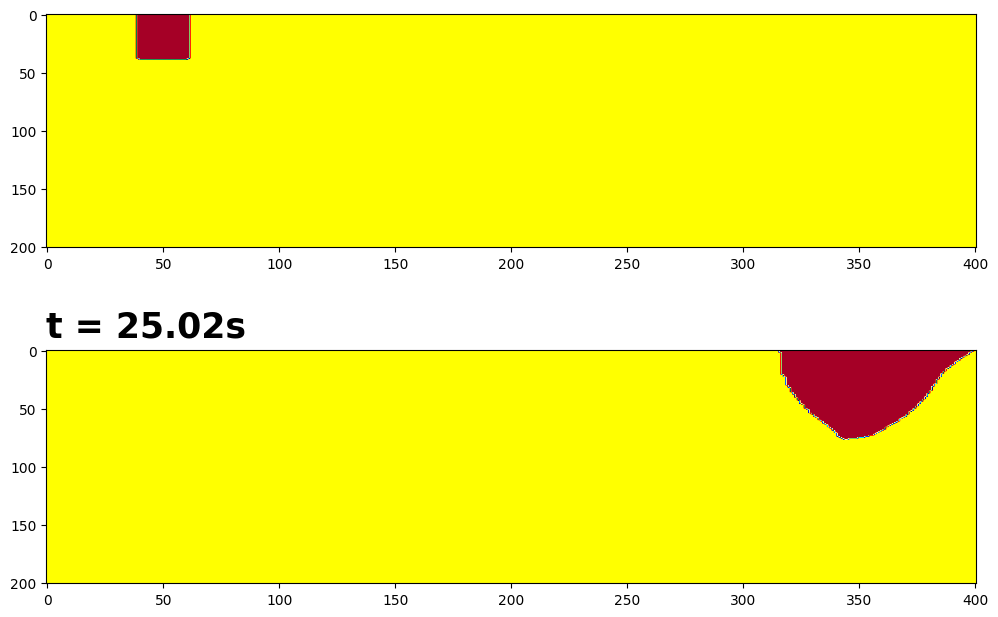

In [13]:
t_step = 500

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8), frameon=True)
cmap = cold2hot
cmap.set_under('white', alpha=0)
hmap1 = ax1.imshow(FCC[:,:,0], cmap=cmap, vmin=0.5, vmax=1.0, aspect=0.5,  interpolation='bilinear')
cmap = plt.get_cmap('RdYlGn_r')
cmap.set_under('white', alpha=0) 
hmap2 = ax1.imshow(LIQ[:,:,0], cmap=cmap, vmin=0.5, vmax=1.0, aspect=0.5, interpolation='bilinear')

cmap = cold2hot
cmap.set_under('white', alpha=0)
hmap1 = ax2.imshow(FCC[:,:,t_step], cmap=cmap, vmin=0.5, vmax=1.0, aspect=0.5,  interpolation='bilinear')
cmap = plt.get_cmap('RdYlGn_r')
cmap.set_under('white', alpha=0) 
hmap2 = ax2.imshow(LIQ[:,:,t_step], cmap=cmap, vmin=0.5, vmax=1.0, aspect=0.5, interpolation='bilinear')
ax2.set_title(f't = {time[t_step]:.2f}s', pad=10, loc='left', fontsize=25, weight='bold')
plt.show()

# FlatTop HS

## TDB Free Energy

In [ ]:
path = os.path.abspath('../../0_MOOSE_Input_Files/Heat_Sources/FlatTop/TDB/exodus/')

In [ ]:
model_path = path+'/Au-Au.e'
model = netCDF4.Dataset(model_path)

In [ ]:
model.dimensions

In [ ]:
model.variables.keys()

In [ ]:
names = model.variables["name_nod_var"]
names.set_auto_mask(False)
param_in_exodus = [b"".join(c).decode("latin1") for c in names[:]]
print(param_in_exodus)

In [ ]:
parameters = ['vals_nod_var1', 'vals_nod_var2', 'vals_nod_var3', 'vals_nod_var4', 'vals_nod_var5',]

In [ ]:
area_df1 = pd.read_csv(path+'/Au-Au.csv',  encoding='utf-8')
real_time = np.array(area_df1['time'])
area_df1.head()

In [ ]:
LIQ, press, temp, velX, velY = [], [], [], [], []

for i in range(5):
    param = model.variables[parameters[i]][:]

    X_all = model.variables['coordx'][:]
    Y_all = model.variables['coordy'][:]
    
    points = np.vstack([Y_all,X_all,param]).T
    
    column_names = ['X', 'Y'] + list(range(param.shape[0]))
    df = pd.DataFrame(points, columns=column_names)
    df = df.sort_values(by = ['X', 'Y'], ascending = [True, True], ignore_index=True)
    df_param = df.iloc[:, 2:]
    
    x_dim  = model.dimensions['num_nod_ns1'].size
    y_dim =  model.dimensions['num_nod_ns2'].size
    time_steps = model.dimensions['time_step'].size
    array_ = df_param.to_numpy().flatten().reshape(y_dim, x_dim, time_steps)
    array = np.flip(array_, axis=0)
    if i == 0:
        LIQ.append(array)
    elif i == 1:
        press.append(array)
    elif i == 2:
        temp.append(array)
    elif i == 3:
        velX.append(array)
    else:
        velY.append(array)

# time = np.array(model.variables['time_whole'][:]).reshape((-1, ))
# LIQ, press, temp, velX, velY, = np.clip(LIQ[0][:,:,:], 0, 1), press[0][:,:,:], temp[0][:,:,:], velX[0][:,:,:], velY[0][:,:,:]
# FCC = 1 - LIQ
# vel = (velX**2 + velY**2)**0.5

In [ ]:
t_ST = 27
time = np.array(model.variables['time_whole'][:]).reshape((-1, ))[np.r_[0,t_ST:time_steps]]
LIQ, press, temp, velX, velY, = np.where(LIQ[0] < 0.5, 0, 1)[:, :, np.r_[0, t_ST:time_steps]], press[0][:, :, np.r_[0, t_ST:time_steps]], temp[0][:, :, np.r_[0, t_ST:time_steps]], velX[0][:, :, np.r_[0, t_ST:time_steps]], velY[0][:, :, np.r_[0, t_ST:time_steps]]
FCC = 1- LIQ
vel = (velX**2 + velY**2)**0.5

In [ ]:
##########################################
# Saving as Npmpy Files
path = os.path.abspath('../../1_Simulation_Results/numpy_files/FlatTop/TDB/')
np.save(path+'/LIQ.npy', LIQ)
np.save(path+'/FCC.npy', FCC)
np.save(path+'/vel.npy', vel)
np.save(path+'/temp.npy', temp)
np.save(path+'/time.npy', time)

np.savez(path+'/FlatTop_TDB.npz', arr1=LIQ, arr2=FCC, arr3=vel, arr4=temp, arr5=time)

In [ ]:
t_step = 2

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8), frameon=True)
cmap = cold2hot
cmap.set_under('white', alpha=0)
hmap1 = ax1.imshow(FCC[:,:,0], cmap=cmap, vmin=0.5, vmax=1.0, aspect=0.5,  interpolation='bilinear')
cmap = plt.get_cmap('RdYlGn_r')
cmap.set_under('white', alpha=0) 
hmap2 = ax1.imshow(LIQ[:,:,0], cmap=cmap, vmin=0.5, vmax=1.0, aspect=0.5, interpolation='bilinear')

cmap = cold2hot
cmap.set_under('white', alpha=0)
hmap1 = ax2.imshow(FCC[:,:,t_step], cmap=cmap, vmin=0.5, vmax=1.0, aspect=0.5,  interpolation='bilinear')
cmap = plt.get_cmap('RdYlGn_r')
cmap.set_under('white', alpha=0) 
hmap2 = ax2.imshow(LIQ[:,:,t_step], cmap=cmap, vmin=0.5, vmax=1.0, aspect=0.5, interpolation='bilinear')
# print(time[t_step])

In [ ]:
t_step = 1
fig, ax1 = plt.subplots(1,1, figsize=(12,8), frameon=True)
cmap = plt.get_cmap('RdYlGn_r')
cmap.set_under('white', alpha=0)
hmap1 = ax1.imshow(temp[:,:,t_step], cmap=cmap,  aspect=0.5,  interpolation='bilinear')

## Fitted Free Energy

In [ ]:
path = os.path.abspath('../../0_MOOSE_Input_Files/Heat_Sources/FlatTop/Fitting/exodus/')

In [ ]:
model_path = path+'/Au-Au.e'
model = netCDF4.Dataset(model_path)

In [ ]:
model.dimensions

In [ ]:
model.variables.keys()

In [ ]:
names = model.variables["name_nod_var"]
names.set_auto_mask(False)
param_in_exodus = [b"".join(c).decode("latin1") for c in names[:]]
print(param_in_exodus)

In [ ]:
parameters = ['vals_nod_var1', 'vals_nod_var2', 'vals_nod_var3', 'vals_nod_var4', 'vals_nod_var5',]

In [ ]:
area_df1 = pd.read_csv(path+'/Au-Au.csv',  encoding='utf-8')
real_time = np.array(area_df1['time'])
area_df1.tail()

In [ ]:
LIQ, press, temp, velX, velY = [], [], [], [], []

for i in range(5):
    param = model.variables[parameters[i]][:]

    X_all = model.variables['coordx'][:]
    Y_all = model.variables['coordy'][:]
    
    points = np.vstack([Y_all,X_all,param]).T
    
    column_names = ['X', 'Y'] + list(range(param.shape[0]))
    df = pd.DataFrame(points, columns=column_names)
    df = df.sort_values(by = ['X', 'Y'], ascending = [True, True], ignore_index=True)
    df_param = df.iloc[:, 2:]
    
    x_dim  = model.dimensions['num_nod_ns1'].size
    y_dim =  model.dimensions['num_nod_ns2'].size
    time_steps = model.dimensions['time_step'].size
    array_ = df_param.to_numpy().flatten().reshape(y_dim, x_dim, time_steps)
    array = np.flip(array_, axis=0)
    if i == 0:
        LIQ.append(array)
    elif i == 1:
        press.append(array)
    elif i == 2:
        temp.append(array)
    elif i == 3:
        velX.append(array)
    else:
        velY.append(array)

# time = np.array(model.variables['time_whole'][:]).reshape((-1, ))
# LIQ, press, temp, velX, velY, = np.clip(LIQ[0][:,:,:], 0, 1), press[0][:,:,:], temp[0][:,:,:], velX[0][:,:,:], velY[0][:,:,:]
# FCC = 1- LIQ
# vel = (velX**2 + velY**2)**0.5

In [ ]:
t_ST = 40
time = np.array(model.variables['time_whole'][:]).reshape((-1, ))[np.r_[0,t_ST:time_steps]]
LIQ, press, temp, velX, velY, = np.where(LIQ[0] < 0.5, 0, 1)[:, :, np.r_[0, t_ST:time_steps]], press[0][:, :, np.r_[0, t_ST:time_steps]], temp[0][:, :, np.r_[0, t_ST:time_steps]], velX[0][:, :, np.r_[0, t_ST:time_steps]], velY[0][:, :, np.r_[0, t_ST:time_steps]]
FCC = 1- LIQ
vel = (velX**2 + velY**2)**0.5

In [ ]:
##########################################
# Saving as Npmpy Files
path = os.path.abspath('../../1_Simulation_Results/numpy_files/FlatTop/Fitting/')
np.save(path+'/LIQ.npy', LIQ)
np.save(path+'/FCC.npy', FCC)
np.save(path+'/vel.npy', vel)
np.save(path+'/temp.npy', temp)
np.save(path+'/time.npy', time)

np.savez(path+'/FlatTop_Fitting.npz', arr1=LIQ, arr2=FCC, arr3=vel, arr4=temp, arr5=time)

In [ ]:
t_step = 494

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8), frameon=True)
cmap = cold2hot
cmap.set_under('white', alpha=0)
hmap1 = ax1.imshow(FCC[:,:,0], cmap=cmap, vmin=0.5, vmax=1.0, aspect=0.5,  interpolation='bilinear')
cmap = plt.get_cmap('RdYlGn_r')
cmap.set_under('white', alpha=0) 
hmap2 = ax1.imshow(LIQ[:,:,0], cmap=cmap, vmin=0.5, vmax=1.0, aspect=0.5, interpolation='bilinear')

cmap = cold2hot
cmap.set_under('white', alpha=0)
hmap1 = ax2.imshow(FCC[:,:,t_step], cmap=cmap, vmin=0.5, vmax=1.0, aspect=0.5,  interpolation='bilinear')
cmap = plt.get_cmap('RdYlGn_r')
cmap.set_under('white', alpha=0) 
hmap2 = ax2.imshow(LIQ[:,:,t_step], cmap=cmap, vmin=0.5, vmax=1.0, aspect=0.5, interpolation='bilinear')

In [ ]:
t_step = 494
fig, ax1 = plt.subplots(1,1, figsize=(12,8), frameon=True)
cmap = plt.get_cmap('RdYlGn_r')
cmap.set_under('white', alpha=0)
hmap1 = ax1.imshow(temp[:,:,t_step], cmap=cmap,  aspect=0.5,  interpolation='bilinear')

# Ring HS

## TDB Free Energy

In [ ]:
path = os.path.abspath('../../0_MOOSE_Input_Files/Heat_Sources/Ring/TDB/exodus/')

In [ ]:
model_path = path+'/Au-Au.e'
model = netCDF4.Dataset(model_path)

In [ ]:
model.dimensions

In [ ]:
model.variables.keys()

In [ ]:
names = model.variables["name_nod_var"]
names.set_auto_mask(False)
param_in_exodus = [b"".join(c).decode("latin1") for c in names[:]]
print(param_in_exodus)

In [ ]:
parameters = ['vals_nod_var1', 'vals_nod_var2', 'vals_nod_var3', 'vals_nod_var4', 'vals_nod_var5',]

In [ ]:
area_df1 = pd.read_csv(path+'/Au-Au.csv',  encoding='utf-8')
real_time = np.array(area_df1['time'])
area_df1.head()

In [ ]:
LIQ, press, temp, velX, velY = [], [], [], [], []

for i in range(5):
    param = model.variables[parameters[i]][:]

    X_all = model.variables['coordx'][:]
    Y_all = model.variables['coordy'][:]
    
    points = np.vstack([Y_all,X_all,param]).T
    
    column_names = ['X', 'Y'] + list(range(param.shape[0]))
    df = pd.DataFrame(points, columns=column_names)
    df = df.sort_values(by = ['X', 'Y'], ascending = [True, True], ignore_index=True)
    df_param = df.iloc[:, 2:]
    
    x_dim  = model.dimensions['num_nod_ns1'].size
    y_dim =  model.dimensions['num_nod_ns2'].size
    time_steps = model.dimensions['time_step'].size
    array_ = df_param.to_numpy().flatten().reshape(y_dim, x_dim, time_steps)
    array = np.flip(array_, axis=0)
    if i == 0:
        LIQ.append(array)
    elif i == 1:
        press.append(array)
    elif i == 2:
        temp.append(array)
    elif i == 3:
        velX.append(array)
    else:
        velY.append(array)

time = np.array(model.variables['time_whole'][:]).reshape((-1, ))
LIQ, press, temp, velX, velY, = np.where(LIQ[0] < 0.5, 0, 1), press[0][:,:,:], temp[0][:,:,:], velX[0][:,:,:], velY[0][:,:,:]
FCC = 1 - LIQ
vel = (velX**2 + velY**2)**0.5

In [ ]:
##########################################
# Saving as Numpy Files
path = os.path.abspath('../../1_Simulation_Results/numpy_files/Ring/TDB/')
np.save(path+'/LIQ.npy', LIQ)
np.save(path+'/FCC.npy', FCC)
np.save(path+'/vel.npy', vel)
np.save(path+'/temp.npy', temp)
np.save(path+'/time.npy', time)

np.savez(path+'/Ring_TDB.npz', arr1=LIQ, arr2=FCC, arr3=vel, arr4=temp, arr5=time)

In [ ]:
t_step = 20

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8), frameon=True)
cmap = cold2hot
cmap.set_under('white', alpha=0)
hmap1 = ax1.imshow(FCC[:,:,0], cmap=cmap, vmin=0.5, vmax=1.0, aspect=0.5,  interpolation='bilinear')
cmap = plt.get_cmap('RdYlGn_r')
cmap.set_under('white', alpha=0) 
hmap2 = ax1.imshow(LIQ[:,:,0], cmap=cmap, vmin=0.5, vmax=1.0, aspect=0.5, interpolation='bilinear')

cmap = cold2hot
cmap.set_under('white', alpha=0)
hmap1 = ax2.imshow(FCC[:,:,t_step], cmap=cmap, vmin=0.5, vmax=1.0, aspect=0.5,  interpolation='bilinear')
cmap = plt.get_cmap('RdYlGn_r')
cmap.set_under('white', alpha=0) 
hmap2 = ax2.imshow(LIQ[:,:,t_step], cmap=cmap, vmin=0.5, vmax=1.0, aspect=0.5, interpolation='bilinear')

In [ ]:
t_step = 1
fig, ax1 = plt.subplots(1,1, figsize=(12,8), frameon=True)
cmap = plt.get_cmap('RdYlGn_r')
cmap.set_under('white', alpha=0)
hmap1 = ax1.imshow(temp[:,:,t_step], cmap=cmap,  aspect=0.5,  interpolation='bilinear')

## Fitted Free Energy

In [ ]:
path = os.path.abspath('../../0_MOOSE_Input_Files/Heat_Sources/Ring/Fitting/exodus/')

In [ ]:
model_path = path+'/Au-Au.e'
model = netCDF4.Dataset(model_path)

In [ ]:
model.dimensions

In [ ]:
model.variables.keys()

In [ ]:
names = model.variables["name_nod_var"]
names.set_auto_mask(False)
param_in_exodus = [b"".join(c).decode("latin1") for c in names[:]]
print(param_in_exodus)

In [ ]:
parameters = ['vals_nod_var1', 'vals_nod_var2', 'vals_nod_var3', 'vals_nod_var4', 'vals_nod_var5',]

In [ ]:
area_df1 = pd.read_csv(path+'/Au-Au.csv',  encoding='utf-8')
real_time = np.array(area_df1['time'])
area_df1.head()

In [ ]:
LIQ, press, temp, velX, velY = [], [], [], [], []

for i in range(5):
    param = model.variables[parameters[i]][:]

    X_all = model.variables['coordx'][:]
    Y_all = model.variables['coordy'][:]
    
    points = np.vstack([Y_all,X_all,param]).T
    
    column_names = ['X', 'Y'] + list(range(param.shape[0]))
    df = pd.DataFrame(points, columns=column_names)
    df = df.sort_values(by = ['X', 'Y'], ascending = [True, True], ignore_index=True)
    df_param = df.iloc[:, 2:]
    
    x_dim  = model.dimensions['num_nod_ns1'].size
    y_dim =  model.dimensions['num_nod_ns2'].size
    time_steps = model.dimensions['time_step'].size
    array_ = df_param.to_numpy().flatten().reshape(y_dim, x_dim, time_steps)
    array = np.flip(array_, axis=0)
    if i == 0:
        LIQ.append(array)
    elif i == 1:
        press.append(array)
    elif i == 2:
        temp.append(array)
    elif i == 3:
        velX.append(array)
    else:
        velY.append(array)

# time = np.array(model.variables['time_whole'][:]).reshape((-1, ))
# LIQ, press, temp, velX, velY, = np.clip(LIQ[0][:,:,:], 0, 1), press[0][:,:,:], temp[0][:,:,:], velX[0][:,:,:], velY[0][:,:,:]
# FCC = 1- LIQ
# vel = (velX**2 + velY**2)**0.5

In [ ]:
t_ST = 22
time = np.array(model.variables['time_whole'][:]).reshape((-1, ))[np.r_[0,t_ST:time_steps]]
LIQ, press, temp, velX, velY, = np.where(LIQ[0] < 0.5, 0, 1)[:, :, np.r_[0, t_ST:time_steps]], press[0][:, :, np.r_[0, t_ST:time_steps]], temp[0][:, :, np.r_[0, t_ST:time_steps]], velX[0][:, :, np.r_[0, t_ST:time_steps]], velY[0][:, :, np.r_[0, t_ST:time_steps]]
FCC = 1- LIQ
vel = (velX**2 + velY**2)**0.5

In [ ]:
##########################################
# Saving as Npmpy Files
path = os.path.abspath('../../1_Simulation_Results/numpy_files/Ring/Fitting/')
np.save(path+'/LIQ.npy', LIQ)
np.save(path+'/FCC.npy', FCC)
np.save(path+'/vel.npy', vel)
np.save(path+'/temp.npy', temp)
np.save(path+'/time.npy', time)

np.savez(path+'/Ring_Fitting.npz', arr1=LIQ, arr2=FCC, arr3=vel, arr4=temp, arr5=time)

In [ ]:
t_step = 1

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8), frameon=True)
cmap = cold2hot
cmap.set_under('white', alpha=0)
hmap1 = ax1.imshow(FCC[:,:,0], cmap=cmap, vmin=0.5, vmax=1.0, aspect=0.5,  interpolation='bilinear')
cmap = plt.get_cmap('RdYlGn_r')
cmap.set_under('white', alpha=0) 
hmap2 = ax1.imshow(LIQ[:,:,0], cmap=cmap, vmin=0.5, vmax=1.0, aspect=0.5, interpolation='bilinear')

cmap = cold2hot
cmap.set_under('white', alpha=0)
hmap1 = ax2.imshow(FCC[:,:,t_step], cmap=cmap, vmin=0.5, vmax=1.0, aspect=0.5,  interpolation='bilinear')
cmap = plt.get_cmap('RdYlGn_r')
cmap.set_under('white', alpha=0) 
hmap2 = ax2.imshow(LIQ[:,:,t_step], cmap=cmap, vmin=0.5, vmax=1.0, aspect=0.5, interpolation='bilinear')

In [ ]:
t_step = 1
fig, ax1 = plt.subplots(1,1, figsize=(12,8), frameon=True)
cmap = plt.get_cmap('RdYlGn_r')
cmap.set_under('white', alpha=0)
hmap1 = ax1.imshow(temp[:,:,t_step], cmap=cmap,  aspect=0.5,  interpolation='bilinear')

# Bessel HS

## TDB Free Energy

In [ ]:
path = os.path.abspath('../../0_MOOSE_Input_Files/Heat_Sources/Bessel/TDB/exodus/')

In [ ]:
model_path = path+'/Au-Au.e'
model = netCDF4.Dataset(model_path)

In [ ]:
model.dimensions

In [ ]:
model.variables.keys()

In [ ]:
names = model.variables["name_nod_var"]
names.set_auto_mask(False)
param_in_exodus = [b"".join(c).decode("latin1") for c in names[:]]
print(param_in_exodus)

In [ ]:
parameters = ['vals_nod_var1', 'vals_nod_var2', 'vals_nod_var3', 'vals_nod_var4', 'vals_nod_var5',]

In [ ]:
area_df1 = pd.read_csv(path+'/Au-Au.csv',  encoding='utf-8')
real_time = np.array(area_df1['time'])
area_df1.head()

In [ ]:
LIQ, press, temp, velX, velY = [], [], [], [], []

for i in range(5):
    param = model.variables[parameters[i]][:]

    X_all = model.variables['coordx'][:]
    Y_all = model.variables['coordy'][:]
    
    points = np.vstack([Y_all,X_all,param]).T
    
    column_names = ['X', 'Y'] + list(range(param.shape[0]))
    df = pd.DataFrame(points, columns=column_names)
    df = df.sort_values(by = ['X', 'Y'], ascending = [True, True], ignore_index=True)
    df_param = df.iloc[:, 2:]
    
    x_dim  = model.dimensions['num_nod_ns1'].size
    y_dim =  model.dimensions['num_nod_ns2'].size
    time_steps = model.dimensions['time_step'].size
    array_ = df_param.to_numpy().flatten().reshape(y_dim, x_dim, time_steps)
    array = np.flip(array_, axis=0)
    if i == 0:
        LIQ.append(array)
    elif i == 1:
        press.append(array)
    elif i == 2:
        temp.append(array)
    elif i == 3:
        velX.append(array)
    else:
        velY.append(array)

# time = np.array(model.variables['time_whole'][:]).reshape((-1, ))
# LIQ, press, temp, velX, velY, = np.clip(LIQ[0][:,:,:], 0, 1), press[0][:,:,:], temp[0][:,:,:], velX[0][:,:,:], velY[0][:,:,:]
# FCC = 1 - LIQ
# vel = (velX**2 + velY**2)**0.5

In [ ]:
t_ST = 25
time = np.array(model.variables['time_whole'][:]).reshape((-1, ))[np.r_[0,t_ST:time_steps]]
LIQ, press, temp, velX, velY, = np.where(LIQ[0] < 0.5, 0, 1)[:, :, np.r_[0, t_ST:time_steps]], press[0][:, :, np.r_[0, t_ST:time_steps]], temp[0][:, :, np.r_[0, t_ST:time_steps]], velX[0][:, :, np.r_[0, t_ST:time_steps]], velY[0][:, :, np.r_[0, t_ST:time_steps]]
FCC = 1- LIQ
vel = (velX**2 + velY**2)**0.5

In [ ]:
##########################################
# Saving as Npmpy Files
path = os.path.abspath('../../1_Simulation_Results/numpy_files/Bessel/TDB/')
np.save(path+'/LIQ.npy', LIQ)
np.save(path+'/FCC.npy', FCC)
np.save(path+'/vel.npy', vel)
np.save(path+'/temp.npy', temp)
np.save(path+'/time.npy', time)

np.savez(path+'/Bessel_TDB.npz', arr1=LIQ, arr2=FCC, arr3=vel, arr4=temp, arr5=time)

In [ ]:
t_step = 10

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8), frameon=True)
cmap = cold2hot
cmap.set_under('white', alpha=0)
hmap1 = ax1.imshow(FCC[:,:,0], cmap=cmap, vmin=0.5, vmax=1.0, aspect=0.5,  interpolation='bilinear')
cmap = plt.get_cmap('RdYlGn_r')
cmap.set_under('white', alpha=0) 
hmap2 = ax1.imshow(LIQ[:,:,0], cmap=cmap, vmin=0.5, vmax=1.0, aspect=0.5, interpolation='bilinear')

cmap = cold2hot
cmap.set_under('white', alpha=0)
hmap1 = ax2.imshow(FCC[:,:,t_step], cmap=cmap, vmin=0.5, vmax=1.0, aspect=0.5,  interpolation='bilinear')
cmap = plt.get_cmap('RdYlGn_r')
cmap.set_under('white', alpha=0) 
hmap2 = ax2.imshow(LIQ[:,:,t_step], cmap=cmap, vmin=0.5, vmax=1.0, aspect=0.5, interpolation='bilinear')

In [ ]:
t_step = 1
fig, ax1 = plt.subplots(1,1, figsize=(12,8), frameon=True)
cmap = plt.get_cmap('RdYlGn_r')
cmap.set_under('white', alpha=0)
hmap1 = ax1.imshow(temp[:,:,t_step], cmap=cmap,  aspect=0.5,  interpolation='bilinear')

## Fitted Free Energy

In [ ]:
path = os.path.abspath('../../0_MOOSE_Input_Files/Heat_Sources/Bessel/Fitting/exodus/')

In [ ]:
model_path = path+'/Au-Au.e'
model = netCDF4.Dataset(model_path)

In [ ]:
model.dimensions

In [ ]:
model.variables.keys()

In [ ]:
names = model.variables["name_nod_var"]
names.set_auto_mask(False)
param_in_exodus = [b"".join(c).decode("latin1") for c in names[:]]
print(param_in_exodus)

In [ ]:
parameters = ['vals_nod_var1', 'vals_nod_var2', 'vals_nod_var3', 'vals_nod_var4', 'vals_nod_var5',]

In [ ]:
area_df1 = pd.read_csv(path+'/Au-Au.csv',  encoding='utf-8')
real_time = np.array(area_df1['time'])
area_df1.head()

In [ ]:
LIQ, press, temp, velX, velY = [], [], [], [], []

for i in range(5):
    param = model.variables[parameters[i]][:]

    X_all = model.variables['coordx'][:]
    Y_all = model.variables['coordy'][:]
    
    points = np.vstack([Y_all,X_all,param]).T
    
    column_names = ['X', 'Y'] + list(range(param.shape[0]))
    df = pd.DataFrame(points, columns=column_names)
    df = df.sort_values(by = ['X', 'Y'], ascending = [True, True], ignore_index=True)
    df_param = df.iloc[:, 2:]
    
    x_dim  = model.dimensions['num_nod_ns1'].size
    y_dim =  model.dimensions['num_nod_ns2'].size
    time_steps = model.dimensions['time_step'].size
    array_ = df_param.to_numpy().flatten().reshape(y_dim, x_dim, time_steps)
    array = np.flip(array_, axis=0)
    if i == 0:
        LIQ.append(array)
    elif i == 1:
        press.append(array)
    elif i == 2:
        temp.append(array)
    elif i == 3:
        velX.append(array)
    else:
        velY.append(array)

# time = np.array(model.variables['time_whole'][:]).reshape((-1, ))
# LIQ, press, temp, velX, velY, = np.clip(LIQ[0][:,:,:], 0, 1), press[0][:,:,:], temp[0][:,:,:], velX[0][:,:,:], velY[0][:,:,:]
# FCC = 1- LIQ
# vel = (velX**2 + velY**2)**0.5

In [ ]:
t_ST = 32
time = np.array(model.variables['time_whole'][:]).reshape((-1, ))[np.r_[0,t_ST:time_steps]]
LIQ, press, temp, velX, velY, = np.where(LIQ[0] < 0.5, 0, 1)[:, :, np.r_[0, t_ST:time_steps]], press[0][:, :, np.r_[0, t_ST:time_steps]], temp[0][:, :, np.r_[0, t_ST:time_steps]], velX[0][:, :, np.r_[0, t_ST:time_steps]], velY[0][:, :, np.r_[0, t_ST:time_steps]]
FCC = 1- LIQ
vel = (velX**2 + velY**2)**0.5

In [ ]:
##########################################
# Saving as Npmpy Files
path = os.path.abspath('../../1_Simulation_Results/numpy_files/Bessel/Fitting/')
np.save(path+'/LIQ.npy', LIQ)
np.save(path+'/FCC.npy', FCC)
np.save(path+'/vel.npy', vel)
np.save(path+'/temp.npy', temp)
np.save(path+'/time.npy', time)

np.savez(path+'/Bessel_Fitting.npz', arr1=LIQ, arr2=FCC, arr3=vel, arr4=temp, arr5=time)

In [ ]:
t_step = -1

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8), frameon=True)
cmap = cold2hot
cmap.set_under('white', alpha=0)
hmap1 = ax1.imshow(FCC[:,:,0], cmap=cmap, vmin=0.5, vmax=1.0, aspect=0.5,  interpolation='bilinear')
cmap = plt.get_cmap('RdYlGn_r')
cmap.set_under('white', alpha=0) 
hmap2 = ax1.imshow(LIQ[:,:,0], cmap=cmap, vmin=0.5, vmax=1.0, aspect=0.5, interpolation='bilinear')

cmap = cold2hot
cmap.set_under('white', alpha=0)
hmap1 = ax2.imshow(FCC[:,:,t_step], cmap=cmap, vmin=0.5, vmax=1.0, aspect=0.5,  interpolation='bilinear')
cmap = plt.get_cmap('RdYlGn_r')
cmap.set_under('white', alpha=0) 
hmap2 = ax2.imshow(LIQ[:,:,t_step], cmap=cmap, vmin=0.5, vmax=1.0, aspect=0.5, interpolation='bilinear')

In [ ]:
t_step = -1
fig, ax1 = plt.subplots(1,1, figsize=(12,8), frameon=True)
cmap = plt.get_cmap('RdYlGn_r')
cmap.set_under('white', alpha=0)
hmap1 = ax1.imshow(temp[:,:,t_step], cmap=cmap,  aspect=0.5,  interpolation='bilinear')

In [ ]:

fig, ax1 = plt.subplots(1,1, figsize=(10,6), frameon=True)

cmap = plt.get_cmap('RdYlBu')
cmap.set_under('white', alpha=0)
hmap1 = ax1.imshow(Ti[:,:,t_step], cmap=cmap, vmin=0.3, vmax=1.0, interpolation='bilinear')


cmap=cold2hot
cmap.set_under('white', alpha=0) 
hmap2 = ax1.imshow(IMC1[:,:,t_step], cmap=cmap, vmin=0.3, vmax=0.9, interpolation='bilinear')

cmap = plt.get_cmap('jet')
cmap.set_under('white', alpha=0)
hmap3 = ax1.imshow(Au_LIQ[:,:,t_step], cmap=cmap, vmin=0.3, vmax=0.9, interpolation='bilinear')

cmap = plt.get_cmap('RdYlGn')
cmap.set_under('white', alpha=0) 
hmap4 = ax1.imshow(Au_SOL[:,:,t_step], cmap=cmap, vmin=0.3, vmax=0.9, interpolation='bilinear')
